In [1]:
%cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters
# %cd D:\CodeProjects\Python\Bayesian-Learning-with-Wasserstein-Barycenters\
# Soy una nueva linea

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder

In [4]:
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

G = Generator(LATENT_DIM, CHANNELS_IMG).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)


In [5]:
from pathlib import Path


CURR_PATH = Path(".")
NETS_PATH = CURR_PATH / "wgan_gp" / "networks" 
# FACE_PATH = NETS_PATH / "face_zDim128_gauss_recognized_augmented_WAE_WGAN_loss_mse_64p64"
FACE_PATH = NETS_PATH / "_resnet_face_zDim128_gauss_bs_128_recognized_augmented_WAE_WGAN_loss_l1_32p32"
# FACE_PATH = NETS_PATH / "face_zDim128_gauss_recognized_augmented_WAE_WGAN_64p64"
# FACE_PATH = NETS_PATH / "face_zDim128_gauss_recognized_augmented_64p64"
Path("./wgan_gp/networks/")

DATA_PATH = CURR_PATH / "data" / "face_recognized.npy"


DATA_PATH, FACE_PATH

(PosixPath('data/face_recognized.npy'),
 PosixPath('wgan_gp/networks/_resnet_face_zDim128_gauss_bs_128_recognized_augmented_WAE_WGAN_loss_l1_32p32'))

In [6]:
from wgan_gp.wgan_gp_vae.utils import load_checkpoint

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

Encoder(
  (res_layers): Sequential(
    (res1): ResidualBlock(
      (shortcut): Conv2d(1, 128, kernel_size=(1, 1), stride=(1, 1))
      (resample): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (act_func): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (res2): ResidualBlock(
      (resample): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (act_func): LeakyReLU(negative_slope=0.2)
      (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (res3): ResidualBlock(
      (r

In [7]:

from bwb.distributions.data_loaders import *

In [8]:
import numpy as np

arr = np.load(DATA_PATH)
arr.shape

(148436, 784)

In [9]:
faces = DistributionDrawDataLoader(arr, (28, 28))
faces

DistributionDrawDataLoader((n_models, n_supp)=(148436, 784))

In [10]:
first_face = faces[0]
first_face

In [11]:
import torchvision.transforms as transforms

transform_in = transforms.Compose(
    [
        # From pdf to grayscale
        transforms.Lambda(lambda x: x / torch.max(x)),
        # transforms.Lambda(lambda x: x),
        transforms.ToPILImage(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(1)],
            [0.5 for _ in range(1)],
            ),
    ]
)
transform_in(first_face.grayscale_weights)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

In [12]:
from wgan_gp.wgan_gp_vae.utils import ProjectorOnManifold

proj = ProjectorOnManifold(
    E, G, 
    transform_in=transforms.Compose(
            [
                # From pdf to grayscale
                transforms.Lambda(lambda x: x / torch.max(x)),
                # transforms.Lambda(lambda x: x),
                transforms.ToPILImage(),
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.5 for _ in range(1)],
                    [0.5 for _ in range(1)],
                ),
            ]
        ),
    transform_out=transforms.Compose(
            [
                # Ensure the range is in [0, 1]
                transforms.Lambda(lambda x: x - torch.min(x)),
                transforms.Lambda(lambda x: x / torch.max(x)),
                transforms.Lambda(lambda x: 1 - x),
                transforms.ToPILImage(),
                # transforms.Resize((28, 28)),
                # transforms.ToTensor(),
                # transforms.Lambda(lambda x: x / torch.sum(x)),
                # transforms.Lambda(lambda x: x.squeeze(0)),
            ]
        ))

In [13]:
proj._transform_in(first_face.grayscale_weights)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

In [14]:
import requests
import io

response = requests.get('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))  # Works!

In [15]:
cats = DistributionDrawDataLoader(data, (28, 28))
cats[1]

In [16]:
cat = cats[9]
cat

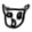

In [17]:
proj(cat.grayscale_weights)

In [18]:
from quickdraw_dataset import QuickDraw
import torchvision.transforms as T
from bwb.distributions import DistributionDraw

ds = QuickDraw(
    Path("./data"), 
    category="cat", 
    recognized=True, 
    download=True, 
    transform=T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x.squeeze()),
        T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x))
    ])
)
ds[0][0]
# proj(ds[0][0])

In [22]:
max_images = 4 * 9
cats_list = []
cats_projected_list = []
for k in range(max_images):
    cat = ds[k][0]
    cats_list.append(cat)
    cats_projected_list.append(proj(cat.grayscale_weights))

In [23]:
from bwb import utils


utils.plot_list_of_draws(cats_list, max_images=max_images)


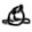
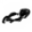
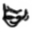
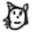
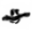
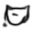
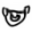
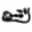
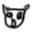
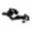
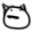
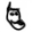
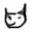
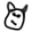
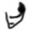
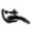
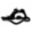
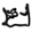
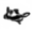
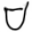
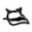
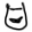
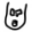
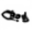
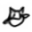
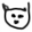
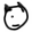
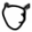
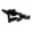
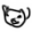
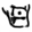
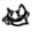
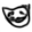
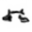
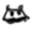
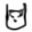


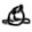
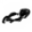
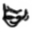
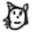
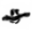
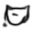
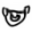
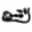
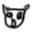
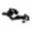
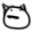
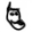
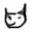
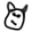
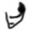
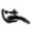
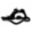
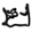
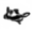
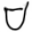
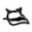
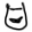
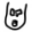
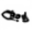
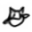
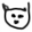
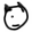
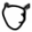
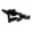
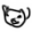
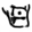
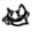
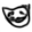
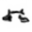
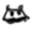
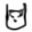

In [24]:
utils.plot_list_of_images(cats_projected_list, max_images=max_images)